## Experimentación

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import matplotlib.pyplot as plt
import pandas as pd
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Cargar el dataset
df_tweets = pd.read_csv('./Datasets/Originales/Tweets_calificados_modelo1.csv')

# Diccionario de palabras con sus puntajes personalizados
word_sentiment_scores = {
    'lluvia': -0.75, 'nublado': -0.25, 'tormenta': -0.50, 'viento': -0.25, 'granizo': -0.75,  # Clima
    'accidente': -0.50, 'choque': -0.75, 'derrape': -0.25, 'atropello': -1.50,  # Accidentes vehiculares
    'tráfico': -0.25, 'atasco': -0.15, 'congestión': -0.10, 'embotellamiento': -0.10,  # Problemas de tráfico
    'inundación': -1.25, 'desborde': -1.25, 'charco': -0.15, 'encharcamiento': -0.25,  # Problemas por agua
    'apagón': -1.25, 'falla': -0.10, 'electricidad': -0.15, 'corte': -0.15, 'colapso': -0.75,  # Problemas eléctricos
    'evacuación': -1.50, 'rescate': -0.75, 'desalojo': -1.50,  # Emergencias
    'muertos': -1.75, 'heridos': -1.00, 'destrucción': -0.75, 'incendio': -1.25,  # Consecuencias graves
    'explosión': -0.75, 'caos': -1.25, 'derrumbes': -1.50, 'colapsos': -1.50,  # Otros desastres
    'afectados': -0.25, 'perdidas': -0.6, 'daños': -0.4, 'colisión': -0.4,  # Impactos generales
    'caída': -0.2, 'árboles': -0.2, 'postes': -0.2, 'barrido': -0.4  # Daños materiales
}

# Convertir el diccionario en una lista de palabras (sin los puntajes)
word_list = list(word_sentiment_scores.keys())

# Crear una función para contar la cantidad de veces que aparece cada palabra en la columna 'Texto'
def count_words_in_text(text, word_list):
    word_count = {word: text.lower().count(word) for word in word_list}
    return pd.Series(word_count)

# Aplicar la función a cada fila de la columna 'Texto'
df_word_counts = df_tweets['Texto'].apply(lambda text: count_words_in_text(text, word_list))

# Ahora vamos a sumar los conteos de todas las filas para obtener el total de apariciones de cada palabra
total_word_counts = df_word_counts.sum()

# Imprimir total_word_counts en orden descendente
print(total_word_counts.sort_values(ascending=False))

lluvia             1463
tormenta            641
incendio            298
accidente           257
inundación          249
daños                96
viento               59
encharcamiento       43
nublado              32
rescate              29
corte                29
desborde             25
tráfico              25
caída                22
granizo              17
falla                17
árboles              17
muertos              13
afectados             8
postes                6
caos                  4
desalojo              4
heridos               4
colapso               4
explosión             3
electricidad          3
apagón                2
atropello             2
derrumbes             1
evacuación            1
charco                1
colisión              0
perdidas              0
congestión            0
colapsos              0
choque                0
destrucción           0
embotellamiento       0
derrape               0
atasco                0
barrido               0
dtype: int64


---

# Análisis de sentimiento V2

In [7]:


# Cargar el modelo y el tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Cargar el dataset
df = pd.read_csv('./Datasets/Originales/Tweets_calificados_modelo1.csv')

# Asignación de valores a las etiquetas de sentimiento del modelo preentrenado
sentiment_labels = [-2, -1, 0, 1, 2]

# Diccionario de palabras con sus puntajes personalizados
word_sentiment_scores = {
    'lluvia': -0.75, 'nublado': -0.25, 'tormenta': -0.50, 'viento': -0.25, 'granizo': -0.75,  # Clima
    'accidente': -0.50, 'choque': -0.75, 'derrape': -0.25, 'atropello': -1.50,  # Accidentes vehiculares
    'tráfico': -0.25, 'atasco': -0.15, 'congestión': -0.10, 'embotellamiento': -0.10,  # Problemas de tráfico
    'inundación': -1.25, 'desborde': -1.25, 'charco': -0.15, 'encharcamiento': -0.25,  # Problemas por agua
    'apagón': -1.25, 'falla': -0.10, 'electricidad': -0.15, 'corte': -0.15, 'colapso': -0.75,  # Problemas eléctricos
    'evacuación': -1.50, 'rescate': -0.75, 'desalojo': -1.50,  # Emergencias
    'muertos': -1.75, 'heridos': -1.00, 'destrucción': -0.75, 'incendio': -1.25,  # Consecuencias graves
    'explosión': -0.75, 'caos': -1.25, 'derrumbes': -1.50, 'colapsos': -1.50,  # Otros desastres
    'afectados': -0.25, 'perdidas': -0.50, 'daños': -0.75, 'colisión': -0.75,  # Impactos generales
    'caída': -0.25, 'árboles': -0.05, 'postes': -0.05, 'barrido': -0.75  # Daños materiales
}

# Convertir el diccionario en una lista de palabras (sin los puntajes)
word_list = list(word_sentiment_scores.keys())

# Función para ajustar el sentimiento según las palabras clave y ajustar su impacto
def adjust_sentiment(text, base_sentiment):
    adjustments = [score for word, score in word_sentiment_scores.items() if word in text.lower()]
    if adjustments:
        # Ajuste dinámico basado en la cantidad de palabras detectadas
        adjustment_factor = sum(adjustments) / len(adjustments)  # Promedio de los ajustes
        base_sentiment += adjustment_factor * (1 - abs(base_sentiment) / 2)  # Ajuste ponderado
    return base_sentiment

# Función para calcular la puntuación de sentimiento
def calculate_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    scores = outputs.logits.detach().numpy()
    scores = softmax(scores[0])
    sentiment_score = sum([a * b for a, b in zip(sentiment_labels, scores)])
    
    # Ajustar la puntuación según las palabras clave
    sentiment_score = adjust_sentiment(text, sentiment_score)
    return sentiment_score

# Aplicar la función a cada texto en la columna 'Texto'
df['Puntaje_v3'] = df['Texto'].apply(calculate_sentiment)

# Guardar el dataframe con las nuevas puntuaciones
df.to_csv('./Datasets/clasificados/df_sentimientos_ajustados.csv', index=False)


c:\Users\aesca\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\aesca\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\modeling_utils.py:519: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowliste

---

## Comparativo entre diferentes versiones

In [ ]:
# Graficar la diferencia entre la columna 'puntaje' y 'puntaje_v3'
import matplotlib.pyplot as plt


---

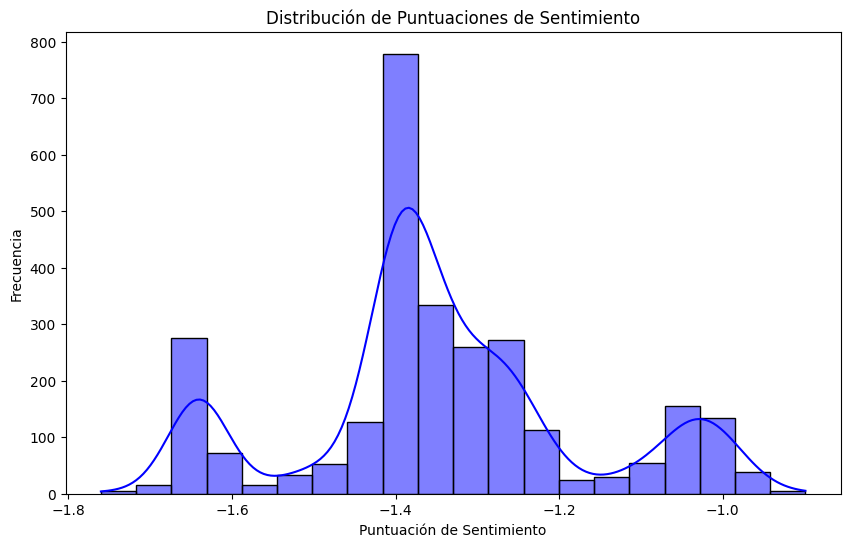

C:\Users\aesca\AppData\Local\Temp\ipykernel_16216\2934195543.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Tipo', y='Puntaje', data=df, ci=None)


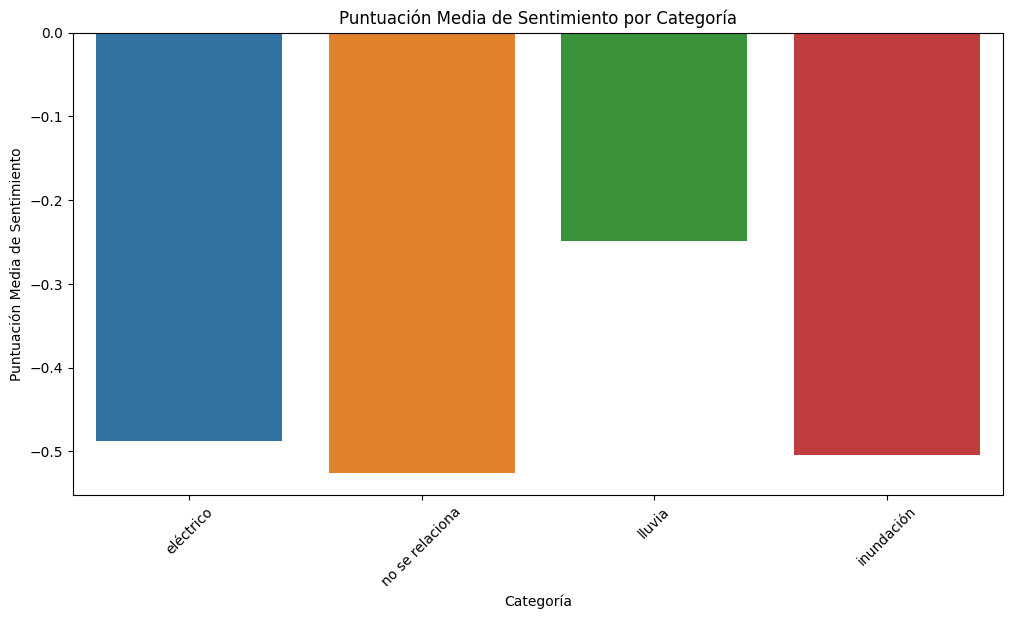

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma de puntuaciones de sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(df['Puntaje_v3'], bins=20, kde=True, color='blue')
plt.title('Distribución de Puntuaciones de Sentimiento')
plt.xlabel('Puntuación de Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

# Si tienes una columna con categorías o temas, por ejemplo 'Category'
# Aquí te muestro cómo hacer un gráfico de barras
if 'Tipo' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Tipo', y='Puntaje', data=df, ci=None)
    plt.title('Puntuación Media de Sentimiento por Categoría')
    plt.xlabel('Categoría')
    plt.ylabel('Puntuación Media de Sentimiento')
    plt.xticks(rotation=45)
    plt.show()

# Scatter plot para visualizar la puntuación a lo largo de otra variable (ej. tiempo)
if 'Timestamp' in df.columns:
    plt.figure(figsize=(14, 6))
    sns.scatterplot(x='Timestamp', y='Sentiment_Score', data=df, hue='Sentiment_Score', palette='coolwarm', alpha=0.7)
    plt.title('Puntuación de Sentimiento a lo Largo del Tiempo')
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Puntuación de Sentimiento')
    plt.show()


## Dudas:

Análisis de sentimiento: ¿la forma en la que manejamos el puntaje se le hace adecuada? Una limitante es que el sentimiento se calcula palabra por palabra, por lo que si una palabra es positiva y otra negativa, el sentimiento final puede ser neutro.

La clasificación se le hace adecuada? La categoría no se relaciona tiene Tweets muy negativos y muchos son relacionados con accidentes de tránsito (pero no se especifica si se ocacionó por la lluvia).

Para la geolocalización tenemos que extraer la ubicación del mismo tweet, ya que no se especifica en el dataset. No todos los tweets incluyen la ubicación.
Las ubicaciones varían entre: calles, avenidas, colonias, municipios y estados. 
¿Lo manejamos en capas? 
¿Qué podemos utilizar para la geolocalización? 
¿Un mapa con puntos en las ubicaciones es el adecuado?

Dos infraestructuras: eléctrica y de transporte

Curiel NLP AUTOR
Becarios - pedir apoyo en el etiquetado, 

GEOPANDAS Y OSMNX
sacar el centroide del poligono
Areas geografícas básicas --> Mastra, Andrés, JP
